# Tag Generation for Yelp Images

 - Download the dataset from https://www.yelp.com/dataset <br>
 - Extract the tar.gz files into yelp_dataset and yelp_photos respectively
 - 

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
import tensorflow 
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import tensorflow as tf
import imutils
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

#### Loading "business.json" file into a dataframe

In [2]:
df_business = pd.read_json("yelp_dataset/business.json", lines=True)
s=0
e=15

In [3]:
C = [df_business['categories']]
ID = df_business['business_id']

In [4]:
business_ids = []
business_categories = []
for i in range(0,len(C)):
    if 'Restaurants' in C[i]:
        business_ids.append(ID[i])
        business_categories.append(C[i])

#### Loading "photo.json" file into a dataframe

In [5]:
df_photos = pd.read_json("yelp_photos/photo.json", lines=True)
print(df_photos.shape)

(200000, 4)


#### Importing Images from dataset

In [6]:
import os
image_size = 256
images_path = ["yelp_photos/photos/"+x for x in df_photos['photo_id']+".jpg"]
train_images=[]
channels = 3

#### Linking photo_id to business_id

In [7]:
photo_id_to_business = [id for id in df_photos['business_id']]
business_id_classes = [i for i in range(len(photo_id_to_business))][s:e]
#print((business_id_classes[:15]))

In [8]:
for image_path in images_path[s:e]:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
    #image = image.reshape(200, image_size,image_size,channels)
    train_images.append(image)
train_images = np.array(train_images, dtype=np.uint8)
train_images = train_images.astype('float32')
train_images = np.multiply(train_images, 1.0/255.0) 
#train_images = train_images.reshape(1, image_size,image_size,channels)

## Data Augmentation

#### Function to resize images

In [9]:
import matplotlib.image as mpimg
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
def resize_tensorflow_images(img_file_paths):
    X_data = []
    ops.reset_default_graph()
    X = tf1.placeholder(tf.float32, (None, None, 3))
    tf_img = tf1.image.resize_images(X, (256, 256), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for file_path in img_file_paths:
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.uint8) # Convert to numpy
    return X_data

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
train_photos = resize_tensorflow_images(images_path[s:e])
print(train_photos.shape)

(15, 256, 256, 3)


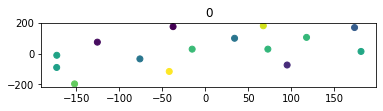

In [11]:
from sklearn.manifold import TSNE
tsne5 = train_photos[s:e].reshape(e-s,-1)
for x in range(1):
    model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=10)
    tsne5 = model.fit_transform(tsne5)

    plt.figure(1)

    plt.subplot(311)
    plt.scatter(tsne5[:,0], tsne5[:, 1], c=np.random.rand(e-s,))
    plt.title(str(x))

    plt.show()

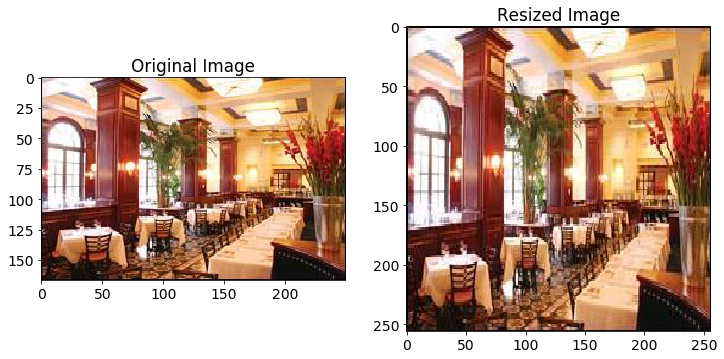

In [12]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(images_path[0])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(train_photos[0])
plt.title('Resized Image')
plt.show()

In [13]:
business_id_scale = []
def central_scale_images(X_imgs, scales):
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([256, 256], dtype = np.int32)
    
    X_scale_data = []
    ops.reset_default_graph()
    X = tf1.placeholder(tf.float32, shape = (1, 256, 256, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer()) 
        bus_class = 0
        for img_data in X_imgs:
            for _ in range(3):
                business_id_scale.append(business_id_classes[bus_class])
            bus_class+=1
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.uint8)
    return X_scale_data

scaled_imgs = central_scale_images(train_photos, [0.90, 0.75, 0.60])
print(scaled_imgs.shape)

(45, 256, 256, 3)


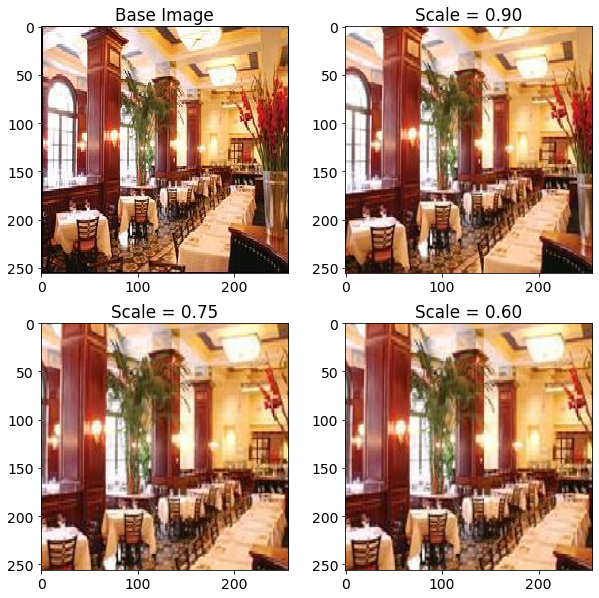

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[0])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(scaled_imgs[0])
plt.title('Scale = 0.90')
plt.subplot(2, 2, 3)
plt.imshow(scaled_imgs[1])
plt.title('Scale = 0.75')
plt.subplot(2, 2, 4)
plt.imshow(scaled_imgs[1])
plt.title('Scale = 0.60')
plt.show()
#print((business_id_scale[:6]),business_id_classes[:6])

In [15]:
from math import ceil, floor
image_dim = 256
business_id_translate = []
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([image_dim, ceil(0.8 * image_dim)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * image_dim))
        h_start = 0
        h_end = image_dim
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([image_dim, ceil(0.8 * image_dim)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * image_dim))
        w_end = image_dim
        h_start = 0
        h_end = image_dim
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * image_dim), image_dim], dtype = np.int32)
        w_start = 0
        w_end = image_dim
        h_start = 0
        h_end = int(ceil(0.8 * image_dim)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * image_dim), image_dim], dtype = np.int32)
        w_start = 0
        w_end = image_dim
        h_start = int(floor((1 - 0.8) * image_dim))
        h_end = image_dim 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.uint8)
    n_translations = 4
    X_translated_arr = []
    
    ops.reset_default_graph()
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), image_dim, image_dim, 3), dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.uint8)
    return X_translated_arr

(60, 256, 256, 3)


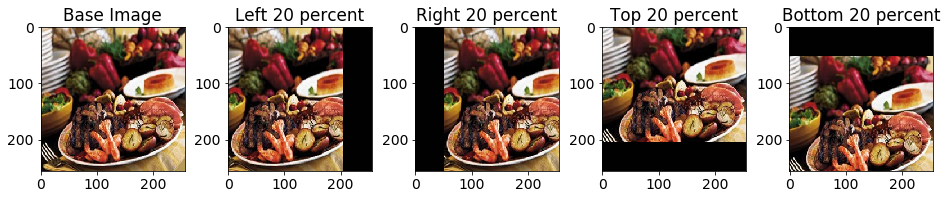

In [16]:
translated_imgs = translate_images(train_photos)
for _ in range(4):
    for x in range(len(train_photos)):
        business_id_translate.append(business_id_classes[x])
print(translated_imgs.shape)
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(train_photos[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[17])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[32])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[47])
plt.title('Bottom 20 percent')
plt.show()

In [17]:
def rotate_images(X_imgs):
    X_rotate = []
    ops.reset_default_graph()
    X = tf1.placeholder(tf.float32, shape = (image_dim, image_dim, 3))
    k = tf1.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.uint8)
    return X_rotate

(45, 256, 256, 3)


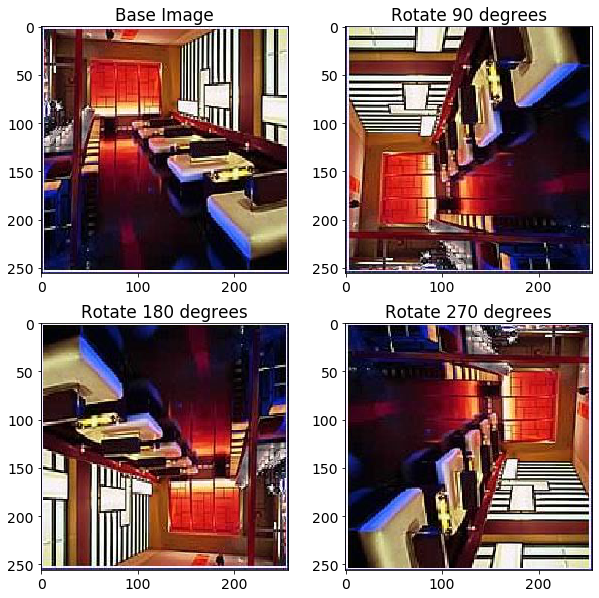

In [18]:
rotated_imgs = rotate_images(train_photos)
business_id_rotate = []
for x in range(len(business_id_classes)):
    for _ in range(3):
        business_id_rotate.append(business_id_classes[x])
print(rotated_imgs.shape)
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[1])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[3])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[4])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[5])
plt.title('Rotate 270 degrees')
plt.show()

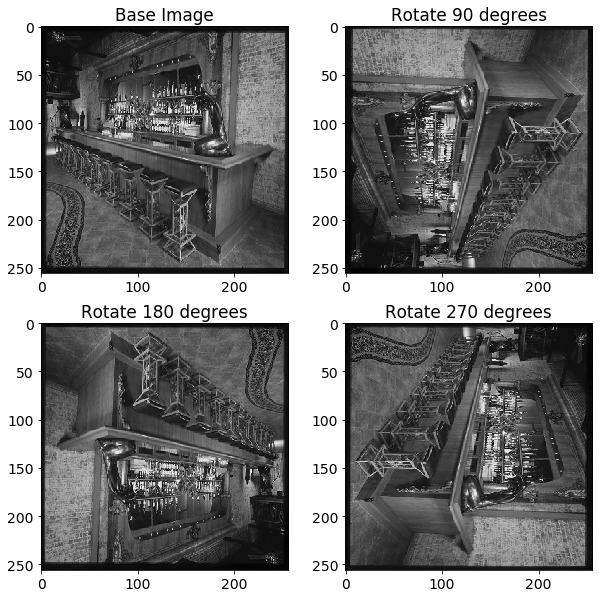

In [19]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[8])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[24])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[25])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[26])
plt.title('Rotate 270 degrees')
plt.show()

In [20]:
import math

def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    ops.reset_default_graph()
    X = tf1.placeholder(tf.float32, shape = (None, image_dim, image_dim, 3))
    radian = tf1.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.image.rot90(X)
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * math.pi / 180  
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.uint8)
    return X_rotate

(210, 256, 256, 3)


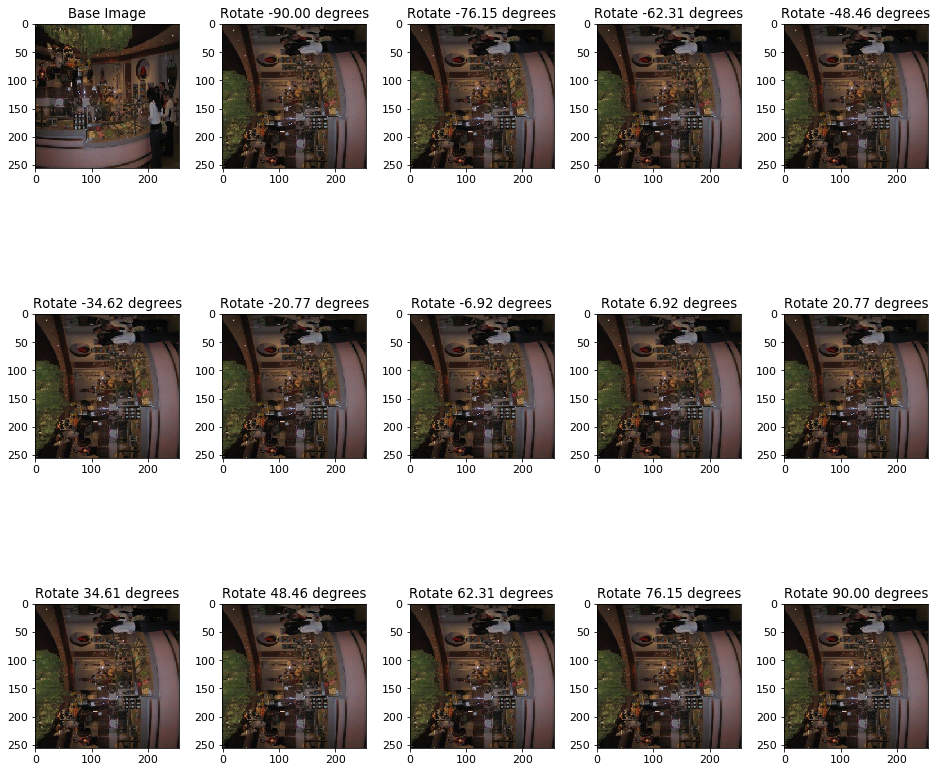

In [21]:
rotated_imgs1 = rotate_images(train_photos, -90, 90, 14)
business_id_rotate1 = []
for _ in range(14):    
    for x in range(len(business_id_classes)):
        business_id_rotate1.append(business_id_classes[x])
print(rotated_imgs1.shape)
matplotlib.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize = (16, 16))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(train_photos[9])
plt.title('Base Image')

for i in range(14):
    plt.subplot(gs[i + 1])
    plt.imshow(rotated_imgs1[9 + 15 * i])
    plt.title('Rotate {:.2f} degrees'.format(-90 + 13.846 * i))
plt.show()

In [22]:
def flip_images(X_imgs):
    X_flip = []
    ops.reset_default_graph()
    X = tf1.placeholder(tf.float32, shape = (image_dim, image_dim, 3))
    tf_img1 = tf1.image.flip_left_right(X)
    tf_img2 = tf1.image.flip_up_down(X)
    tf_img3 = tf1.image.transpose_image(X)
    with tf1.Session() as sess:
        sess.run(tf1.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.uint8)
    return X_flip

(45, 256, 256, 3)
(45, 256, 256, 3)


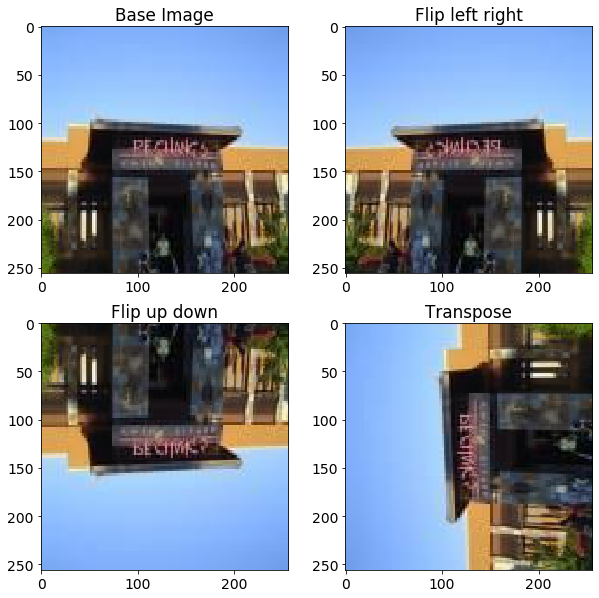

In [23]:
flipped_images = flip_images(train_photos)
business_id_flip = []
for x in range(len(business_id_classes)):
    for _ in range(3):
        business_id_flip.append(business_id_classes[x])
print(rotated_imgs.shape)
print(flipped_images.shape)

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[6])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(flipped_images[18])
plt.title('Flip left right')
plt.subplot(2, 2, 3)
plt.imshow(flipped_images[19])
plt.title('Flip up down')
plt.subplot(2, 2, 4)
plt.imshow(flipped_images[20])
plt.title('Transpose')
plt.show()

In [24]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

(15, 256, 256, 3)


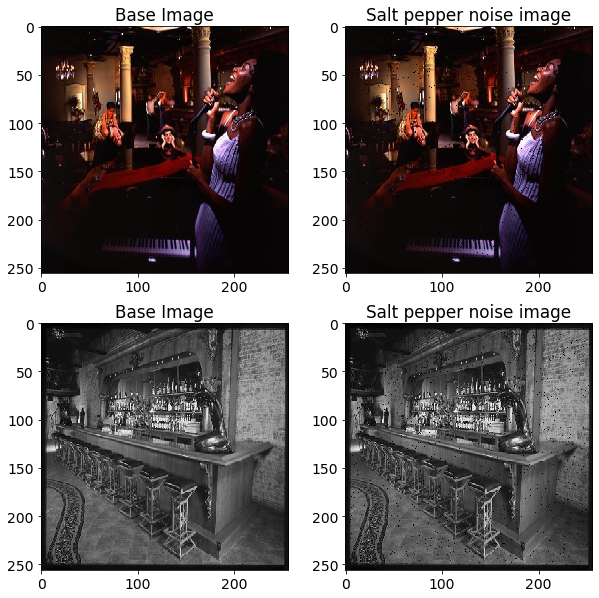

In [25]:
salt_pepper_noise_imgs = add_salt_pepper_noise(train_photos)
business_id_sall_pepper = business_id_classes[:]
print(salt_pepper_noise_imgs.shape)
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(train_photos[7])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_noise_imgs[7])
plt.title('Salt pepper noise image')
plt.subplot(2, 2, 3)
plt.imshow(train_photos[8])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(salt_pepper_noise_imgs[8])
plt.title('Salt pepper noise image')
plt.show()

In [26]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
#    vertices = np.array([[(0.29 * imshape[1], 0.99 * imshape[0]), 
#                          (0.53 * imshape[1], 0.52 * imshape[0]), 
#                          (0.66 * imshape[1], 0.52 * imshape[0]),
#                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                     (X_img.shape[1], X_img.shape[0]),
                                     flags = cv2.INTER_LINEAR)
    return warped_img

(15, 256, 256, 3)


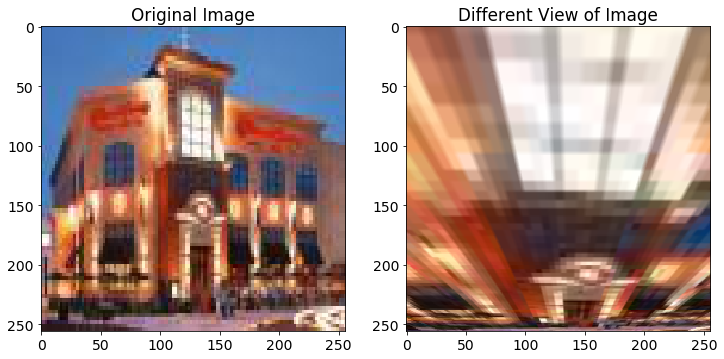

In [27]:
perspective_imgs = []
for X_img in train_photos:
    perspective_imgs.append(perspective_transform(X_img))
perspective_imgs = np.array(perspective_imgs, dtype = np.uint8)
business_id_perspective = business_id_classes[:]
print(perspective_imgs.shape)
fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(train_photos[5])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_imgs[5])
plt.title('Different View of Image')
plt.show()

In [28]:
for x in business_id_scale:
    business_id_classes.append(x)
for x in business_id_flip:
    business_id_classes.append(x)
for x in business_id_perspective:
    business_id_classes.append(x)
for x in business_id_rotate:
    business_id_classes.append(x)
for x in business_id_rotate1:
    business_id_classes.append(x)
for x in business_id_sall_pepper:
    business_id_classes.append(x)
for x in business_id_translate:
    business_id_classes.append(x)
#num_classes = len(set(business_id_classes))
print(len(business_id_classes))

450


In [29]:
train_photos = np.append(train_photos, scaled_imgs, axis=0)
train_photos = np.append(train_photos, flipped_images, axis=0)
train_photos = np.append(train_photos, perspective_imgs, axis=0)
train_photos = np.append(train_photos, rotated_imgs, axis=0)
train_photos = np.append(train_photos, rotated_imgs1, axis=0)
train_photos = np.append(train_photos, salt_pepper_noise_imgs, axis=0)
train_photos = np.append(train_photos, translated_imgs, axis=0)

In [30]:
#train_photos = np.append(train_photos, [scaled_imgs])
print(len((train_photos)))
print(len(business_id_classes))
num_classes = len(set(business_id_classes))
print(num_classes)
lb = preprocessing.LabelBinarizer()
transformed_label = lb.fit_transform(business_id_classes)
print(transformed_label.shape)

450
450
15
(450, 15)


## Model Creation

In [31]:
def layer_weights(dimensions):
    return tensorflow.Variable(tf1.truncated_normal(dimensions, stddev=1./math.sqrt(256*256)))
    #return tensorflow.Variable(tensorflow.truncated_normal([256, 10],
                       #             stddev=1./math.sqrt(256)))
def layer_biases(size):
    return tensorflow.Variable(tensorflow.constant(0.05, shape=[size]))

In [32]:
def make_cnn_layer(input_data,num_of_input_channels,filter_size,num_of_filters):  
    cnn_weights = layer_weights([filter_size,filter_size, num_of_input_channels,num_of_filters])
    cnn_biases = layer_biases(num_of_filters)
    cnn_layer = tf1.nn.conv2d(input=input_data,filter=cnn_weights,
                                     strides=[1, 1, 1, 1],padding='SAME') 
    cnn_layer += cnn_biases
    cnn_layer = tf1.nn.max_pool(value=cnn_layer,ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],padding='SAME')
    cnn_layer = tensorflow.nn.relu(cnn_layer)
    return cnn_layer

In [33]:
def create_fully_conn_layer(input_data,num_of_inputs,num_of_outputs,RELU_FLAG):
    fc_weights = layer_weights([num_of_inputs, num_of_outputs])
    fc_biases = layer_biases(num_of_outputs)
    fc_layer = tensorflow.matmul(input_data, fc_weights) + fc_biases
    if RELU_FLAG:
        fc_layer = tensorflow.nn.relu(fc_layer)
    return fc_layer

In [34]:
def flatten_cnn_layer(layer):
    layershape = layer.get_shape()
    num_of_features = layershape[1:4].num_elements()
    flat_layer = tensorflow.reshape(layer, [-1, num_of_features])
    return flat_layer

In [35]:
x = tf1.placeholder(tensorflow.float32, shape=[None, 256,256,3], name='x')
y_true = tf1.placeholder(tensorflow.float32, shape=[None,num_classes], name='y_true')
y_true_cls = tensorflow.argmax(y_true, axis=1)
channels = 3
filter_size_conv1=3
filter_size_conv2=3
filter_size_conv3=3
num_filters_conv1=64
num_filters_conv2=64
num_filters_conv3=128
fc_layer_size = 256

In [36]:
layer1 = make_cnn_layer(x,channels,filter_size_conv1,num_filters_conv1)
layer2 = make_cnn_layer(layer1,num_filters_conv1,filter_size_conv2,num_filters_conv2)
layer3 = make_cnn_layer(layer2,num_filters_conv2,filter_size_conv3,num_filters_conv3)
layer_flat = flatten_cnn_layer(layer3)
layer_fc1 = create_fully_conn_layer(layer_flat,layer_flat.get_shape()[1:4].num_elements(),fc_layer_size,True)
layer_fc2 = create_fully_conn_layer(layer_fc1,fc_layer_size,num_classes,False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [37]:
num_of_iter = 15
feed_dict_tr = {x: train_photos,
                       y_true: transformed_label}
y_pred = tf1.nn.softmax(layer_fc2,name='y_pred')
y_pred_cls = tf1.argmax(y_pred, axis=1)
session = tf1.Session()
cross_entropy = tf1.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                    labels=y_true)
tensor_cost = tf1.reduce_mean(cross_entropy)
optimizer = tf1.train.AdamOptimizer(learning_rate=1e-4).minimize(tensor_cost)
correct_prediction = tf1.equal(y_pred_cls, y_true_cls)
session.run(tf1.global_variables_initializer())
accuracy = tf1.reduce_mean(tf1.cast(correct_prediction, tensorflow.float32))
for iterations in range(num_of_iter):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 0 ; Loss -  2.7043958
Iteration - 1 ; Loss -  2.696663
Iteration - 2 ; Loss -  2.6813073
Iteration - 3 ; Loss -  2.6604385
Iteration - 4 ; Loss -  2.6313393
Iteration - 5 ; Loss -  2.5874884
Iteration - 6 ; Loss -  2.525472
Iteration - 7 ; Loss -  2.4427478
Iteration - 8 ; Loss -  2.33452
Iteration - 9 ; Loss -  2.1964796
Iteration - 10 ; Loss -  2.0215218
Iteration - 11 ; Loss -  1.8155838
Iteration - 12 ; Loss -  1.6055633
Iteration - 13 ; Loss -  1.4852557
Iteration - 14 ; Loss -  1.2324703


#### Save Initial Progress

In [38]:
saver = tf1.train.Saver()
saver.save(session, 'photo_to_business_model')

'photo_to_business_model'

In [39]:
for iterations in range(25,35):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 25 ; Loss -  1.1581376
Iteration - 26 ; Loss -  1.0838416
Iteration - 27 ; Loss -  0.93257886
Iteration - 28 ; Loss -  0.969321
Iteration - 29 ; Loss -  0.7802127
Iteration - 30 ; Loss -  0.82559615
Iteration - 31 ; Loss -  0.67994106
Iteration - 32 ; Loss -  0.7277202
Iteration - 33 ; Loss -  0.5826588
Iteration - 34 ; Loss -  0.5946838


In [40]:
for iterations in range(35,40):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 35 ; Loss -  0.4782762
Iteration - 36 ; Loss -  0.48409885
Iteration - 37 ; Loss -  0.3832093
Iteration - 38 ; Loss -  0.3843154
Iteration - 39 ; Loss -  0.30603462


In [41]:
for iterations in range(40,45):
    session.run(optimizer, feed_dict=feed_dict_tr)
    eval_loss = session.run(tensor_cost,
                                         feed_dict=feed_dict_tr) 
    print("Iteration -",iterations,"; Loss - ", eval_loss)

Iteration - 40 ; Loss -  0.29936355
Iteration - 41 ; Loss -  0.24836825
Iteration - 42 ; Loss -  0.24178067
Iteration - 43 ; Loss -  0.20514318
Iteration - 44 ; Loss -  0.18205318


#### Save Progress

In [42]:
saver = tf1.train.Saver()
saver.save(session, 'photo_to_business_model')

'photo_to_business_model'

### Function to generate Tags

In [51]:
def tag_generation(image_id):
    image_size=256
    num_channels=3
    images = []
    image = cv2.imread("yelp_photos/photos/"+image_id+".jpg")
    image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
    images.append(image)
    images = np.array(images, dtype=np.uint8)
    images = images.astype('float32')
    images = np.multiply(images, 1.0/255.0) 
    x_batch = images.reshape(1, image_size,image_size,num_channels)
    sess = tf1.Session()
    # Step-1: Recreate the network graph. At this step only graph is created.
    saver_ret = tf1.train.import_meta_graph('photo_to_business_model.meta')
    # Step-2: Now let's load the weights saved using the restore method.
    saver_ret.restore(sess, tf1.train.latest_checkpoint('./'))
    graph = tf1.get_default_graph()

    y_pred = graph.get_tensor_by_name("y_pred:0")

    x= graph.get_tensor_by_name("x:0") 
    y_true = graph.get_tensor_by_name("y_true:0") 
    y_test_images = np.zeros((1, num_classes)) 

    feed_dict_testing = {x: x_batch, y_true: y_test_images}
    result=sess.run(y_pred, feed_dict=feed_dict_testing)
    print(result)

    i = 0
    for photo_id in df_photos['photo_id']:
        if photo_id == image_id:
            break
        i+=1
    output_bus = photo_id_to_business[i]
    i = 0
    for k in ID:
        if k == output_bus:
            break
        i+=1
    Cat_out = C[0][i]
    Cat_out = Cat_out.split(', ')
    fig, ax = plt.subplots(figsize = (12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(mpimg.imread("yelp_photos/photos/"+image_id+".jpg")[:,:,:3])
    plt.title([C for C in Cat_out if C not in ['Restaurants','restaurants']])
    plt.show()

#### Examples

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00925021 0.08637941 0.03846175 0.01920856 0.00423771 0.00883766
  0.00302128 0.58158547 0.01809197 0.07842757 0.02896938 0.00314359
  0.02210561 0.09588087 0.00239899]]


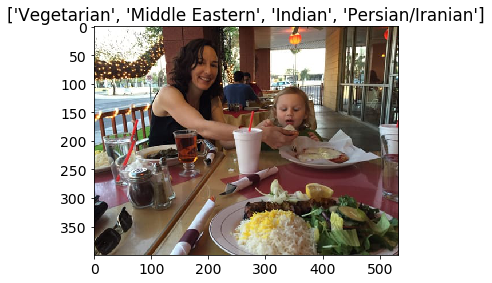

In [55]:
tag_generation("__1RjZ8f0jfznHs51hPRSQ")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00937428 0.08658954 0.03832483 0.01941439 0.00430501 0.00899297
  0.00301635 0.57875013 0.01824497 0.07852392 0.02985582 0.00320282
  0.02240008 0.09658689 0.00241798]]


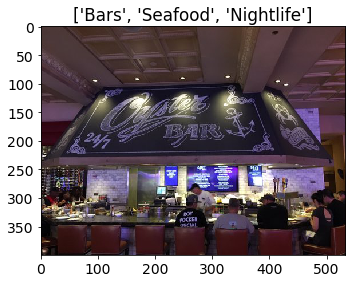

In [56]:
tag_generation("__1mGY39pF_bQvF8YDw0pg")

### Test image IDs
876EKnk6deA7xA4i1aipJg <br>
kIJaFX1mxw_UlAgSPXXmUw <br>
__1RjZ8f0jfznHs51hPRSQ <br>